Plot to compute the first level maps 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from glob import glob
import os
import regex as re
from tqdm import tqdm
from nilearn import image, plotting, glm
from joblib import Parallel, delayed
from joblib import dump, load
from matplotlib.colors import TwoSlopeNorm
from sklearn.preprocessing import maxabs_scale, minmax_scale
import scipy 
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import multipletests

from cofluctuate_bold_glm import NiftiEdgeAtlas
from pathlib import Path

import sys
sys.path.append("..")
from src import get_denoise_opts, get_first_level_opts
from src.input_data import get_bold_files, get_confounders_df
from src.utils import create_edge_mask_from_atlas
from src.first_level import edge_img_first_level, get_contrasts

/home/javi/Documentos/software/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
#Subject to use
final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
print("first 10 subjects: ", final_subjects[:10])

# Shen Atlas
atlas_file = "../../data/shen_2mm_268_parcellation.nii.gz"
print("atlas file: ", atlas_file)

event_file = "../data/task-stroop_events.tsv"
print("events file: ", event_file)

confounders_regex = "trans|rot|white_matter$|csf$"
print("nuisance covariates:", confounders_regex)

# Get denoise options
denoise_opts = get_denoise_opts()

# Get first level options
first_level_opts = get_first_level_opts()

# Number of jobs to use 
n_jobs = 10
print("number of parallel jobs to run = %d" % n_jobs)

first 10 subjects:  [2049. 2050. 1026. 1028. 1025. 2055. 2058. 2059. 2060. 2062.]
atlas file:  ../../data/shen_2mm_268_parcellation.nii.gz
events file:  ../data/task-stroop_events.tsv
nuisance covariates: trans|rot|white_matter$|csf$
getting denoise options:  {'t_r': 2.0, 'high_pass': 0.0053475935828877, 'detrend': False, 'fir_delays': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
getting first level options:  {'t_r': 2.0, 'hrf_model': 'glover + derivative + dispersion', 'smoothing_fwhm': None, 'drift_model': None, 'signal_scaling': False}
number of parallel jobs to run = 10


In [3]:
def save_results(list_first_levels, output_dir, contrasts):
        
    # Save these results
    for subj, fmri_glm in tqdm(zip(final_subjects, list_first_levels), leave=0):
        subject_dir = os.path.join(output_dir, "sub-%d" % subj)

        if os.path.exists(subject_dir) is False:
            os.mkdir(subject_dir)

        # First of all, dump glm_fit object to disk, as in sklearn using joblib
        # This can be useful to use directly on SecondLevelObjects (turn it off for now for space problems)

        for contrast in contrasts:
            contrast_res_dir = os.path.join(subject_dir, contrast)
            
            if os.path.exists(contrast_res_dir) is False:
                os.mkdir(contrast_res_dir)

            res_dict = fmri_glm.compute_contrast(contrast_def=contrast, output_type="all")
            res_dict['z_score'].to_filename(os.path.join(contrast_res_dir, "zstat.nii.gz"))
            res_dict['stat'].to_filename(os.path.join(contrast_res_dir, "tstat.nii.gz"))
            res_dict['p_value'].to_filename(os.path.join(contrast_res_dir, "pvalues.nii.gz"))
            res_dict['effect_size'].to_filename(os.path.join(contrast_res_dir, "cope.nii.gz"))
            res_dict['effect_variance'].to_filename(os.path.join(contrast_res_dir, "varcope.nii.gz"))

def run_first_level_edge_analysis(task_id, 
                                  output_dir, 
                                  intercept_only = False, 
                                  n_jobs=5):
    assert (task_id=="stroop") | (task_id=="msit") | (task_id=="rest")
    
    print("Running %s, and fitting an intercept only model = %r  " % (task_id, 
                                                                      intercept_only)
         )

    
    # For rest we don't denoise any task and only fit an intercept model
    
    # Get preprocessed bold images
    run_imgs = get_bold_files(task_id = task_id, 
                              data_dir = "../", 
                              subjects = final_subjects)
    # Get confounders files
    conf_dfs = get_confounders_df(task_id = task_id, 
                                  data_dir = "../", 
                                  subjects = final_subjects,
                                  confounders_regex = confounders_regex)
    
    if task_id == "rest":
        events_file = None  
        intercept_only = True
    else:
        events_file = "../data/task-%s_events.tsv" % task_id
        
        
    # Get mask for first level
    mask_img = create_edge_mask_from_atlas(atlas_file = atlas_file)
    
    # Get contrast depedning
    contrasts = get_contrasts(intercept_only)
    
    parallel = Parallel(n_jobs=n_jobs)
    
    print("Computing first level analysis for the edge time series...")
    compute_first_level = edge_img_first_level
    list_first_levels = parallel(delayed(compute_first_level)(run_img = run_img, 
                                                              events_file = events_file, 
                                                              conf_df = conf_df, 
                                                              atlas_file = atlas_file,
                                                              denoise_opts = denoise_opts,
                                                              first_level_opts = first_level_opts,
                                                              mask_img = mask_img,
                                                              intercept_only = intercept_only) \
                                 for run_img, conf_df in tqdm(zip(run_imgs, conf_dfs), leave=0))
    
    Path(output_dir).mkdir(exist_ok=True, parents=True)
    output_dir = Path(output_dir).absolute().as_posix()

    print("Saving these results..")
    
    save_results(list_first_levels=list_first_levels, output_dir=output_dir, contrasts=contrasts)

    del parallel
    del list_first_levels
    import gc
    _ = gc.collect()

# STROOP

In [4]:
output_dir = "../task-stroop/first-level-nilearn/edge"
intercept_only = False
run_first_level_edge_analysis(task_id="stroop", 
                              output_dir = output_dir,
                              intercept_only=intercept_only,
                              n_jobs=n_jobs)

Running stroop, and fitting an intercept only model = False  


0it [00:00, ?it/s]

Computing first level analysis for the edge time series...


0it [00:00, ?it/s]      

Saving these results..


In [5]:
output_dir = "../task-stroop/first-level-nilearn/edge_intercept"
intercept_only = True
run_first_level_edge_analysis(task_id="stroop", 
                              output_dir = output_dir,
                              intercept_only=intercept_only,
                              n_jobs=n_jobs)

Running stroop, and fitting an intercept only model = True  


0it [00:00, ?it/s]

Computing first level analysis for the edge time series...


0it [00:00, ?it/s]      

Saving these results..


# MSIT

In [6]:
output_dir = "../task-msit/first-level-nilearn/edge"
intercept_only = False
run_first_level_edge_analysis(task_id="msit", 
                              output_dir = output_dir,
                              intercept_only=intercept_only,
                              n_jobs=n_jobs)

Running msit, and fitting an intercept only model = False  


0it [00:00, ?it/s]

Computing first level analysis for the edge time series...


/home/javi/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
0it [00:00, ?it/s]

Saving these results..


In [7]:
output_dir = "../task-msit/first-level-nilearn/edge_intercept"
intercept_only = True
run_first_level_edge_analysis(task_id="msit", 
                              output_dir = output_dir,
                              intercept_only=intercept_only,
                              n_jobs=n_jobs)

Running msit, and fitting an intercept only model = True  


0it [00:00, ?it/s]

Computing first level analysis for the edge time series...


0it [00:00, ?it/s]      

Saving these results..


# REST

In [8]:
output_dir = "../task-rest/first-level-nilearn/edge_intercept"
intercept_only = True
run_first_level_edge_analysis(task_id = "rest", 
                              output_dir = output_dir,
                              intercept_only = intercept_only,
                              n_jobs=n_jobs)

Running rest, and fitting an intercept only model = True  


0it [00:00, ?it/s]

Computing first level analysis for the edge time series...


0it [00:00, ?it/s]      

Saving these results..


Let's try four different scenarios, for which we can see how are the trajetories of stroop edges with respet to resting:

    1-Before denoising the ROI time series with the FIR task events, with the intercept
    2-After denoising the ROI time series with the FIR task events, with the intercept
    3-Using the baseline (intercept), regressing the edge time series onto the task events

I've seen that, in contrast to what we believed, 2 was closer to resting than 3. This would not contradict anything because one can argue that resting is made up of infintesimal task events, so removing them could just make task edge time series be further away from resting...


In [22]:
from nilearn.glm.first_level import make_first_level_design_matrix


(280, 6)

In [23]:
# Let's try with n_subjects
n_subjects = 100 

# take the data
run_imgs_stroop, conf_dfs_stroop, event_file = get_files("stroop")
run_imgs_resting, conf_dfs_resting, _ = get_files("rest")
events_df = pd.read_csv(event_file, sep="\t")

# This if we want to use the hrf basis functions to denoise
# If we pass a file, it does FIR
frame_times = np.linspace(0, 279*2, 280)
task_conf = make_first_level_design_matrix(frame_times, 
                               events=events_df, 
                               drift_model=None,
                               hrf_model='glover + derivative + dispersion').filter(regex="Congruent|Incongruent").to_numpy()
task_conf

# Object to create the edge time series
edge_atlas = NiftiEdgeAtlas(atlas_file = atlas_file, detrend=False, high_pass=high_pass, t_r=t_r, fir_delays=fir_delays)

# Create a mask for the upper triangular only
mask_data = np.zeros(shape=(268,268), dtype=int)
mask_data[np.triu_indices_from(mask_data, k=1)]=1
mask_data = mask_data[:,:,None]
mask_img = image.new_img_like(run_imgs_stroop[0], data=mask_data)

# Object to perform first level glm
first_level = glm.first_level.FirstLevelModel(mask_img=mask_img, **first_level_opts)

# Matrix just for intercept designs only
intercept_dm_task = pd.DataFrame({'constant': [1]*280})
intercept_dm_resting = pd.DataFrame({'constant': [1]*150})



In [24]:
# Case 1
intercepts_1 = []
for run_img, conf_df in tqdm(zip(run_imgs_stroop[:n_subjects],conf_dfs_stroop[:n_subjects])):
    # No task events denoising
    edge_img = edge_atlas.fit_transform(run_img=run_img, events=None, confounds=conf_df)
    # Intercept only in the first level
    res_first_level = first_level.fit(run_imgs=edge_img, design_matrices=intercept_dm_task)
    
    alpha_res = res_first_level.compute_contrast('constant', output_type='effect_size')
    
    intercepts_1.append(squareform(np.squeeze(alpha_res.get_fdata()), checks=False))

100it [10:36,  6.36s/it]


In [25]:
# Case 2
intercepts_2 = []
for run_img, conf_df in tqdm(zip(run_imgs_stroop[:n_subjects],conf_dfs_stroop[:n_subjects])):
    # Task events denoising
    edge_img = edge_atlas.fit_transform(run_img=run_img, events=task_conf, confounds=conf_df)
    # Intercept only in the first level
    res_first_level = first_level.fit(run_imgs=edge_img, design_matrices=intercept_dm_task)
    
    alpha_res = res_first_level.compute_contrast('constant', output_type='effect_size')
    
    intercepts_2.append(squareform(np.squeeze(alpha_res.get_fdata()), checks=False))

100it [10:33,  6.33s/it]


In [26]:
# Case 3
intercepts_3 = []
for run_img, conf_df in tqdm(zip(run_imgs_stroop[:n_subjects], conf_dfs_stroop[:n_subjects])):
    # Task events denoising
    edge_img = edge_atlas.fit_transform(run_img=run_img, events=task_conf, confounds=conf_df)
    # Task regressors in first level
    res_first_level = first_level.fit(run_imgs=edge_img, events=event_file)
    
    alpha_res = res_first_level.compute_contrast('constant', output_type='effect_size')
    
    intercepts_3.append(squareform(np.squeeze(alpha_res.get_fdata()), checks=False))

100it [10:42,  6.42s/it]


In [74]:
image.load_img(run_imgs_stroop[0]).shape

(61, 73, 65, 280)

In [27]:
# Resting
intercepts_rest = []
for run_img, conf_df in tqdm(zip(run_imgs_resting[:n_subjects],conf_dfs_resting[:n_subjects])):
    # Obviously, here we don't have task events
    edge_img = edge_atlas.fit_transform(run_img=run_img, events=None, confounds=conf_df)
    # And we only have the intercept
    res_first_level = first_level.fit(run_imgs=edge_img, design_matrices=intercept_dm_resting)
    
    alpha_res = res_first_level.compute_contrast('constant', output_type='effect_size')
    
    intercepts_rest.append(squareform(np.squeeze(alpha_res.get_fdata()), checks=False))

100it [07:25,  4.45s/it]


Text(0.5, 1.0, 'Correlation distance between intercepts \n task-based networks w.r.t intercept resting-state networks')

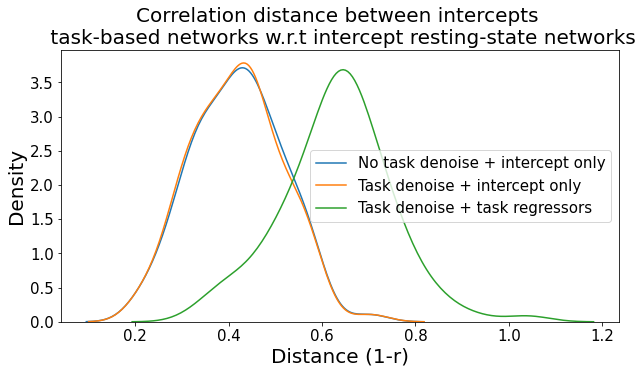

In [75]:
from scipy.spatial.distance import euclidean, correlation
import seaborn as sns
fig = plt.figure(figsize=(10,5))
sns.kdeplot([correlation(a,b) for (a,b) in zip(intercepts_1, intercepts_rest)], label="No task denoise + intercept only")
sns.kdeplot([correlation(a,b) for (a,b) in zip(intercepts_2, intercepts_rest)], label="Task denoise + intercept only" )
sns.kdeplot([correlation(a,b) for (a,b) in zip(intercepts_3, intercepts_rest)], label="Task denoise + task regressors")
plt.legend(fontsize=15)
plt.xlabel("Distance (1-r)", size=20)
plt.ylabel("Density", size=20)
plt.yticks(None)
plt.tick_params(labelsize=15)
plt.title("Correlation distance between intercepts \n task-based networks w.r.t intercept resting-state networks", size=20)

In [92]:
from sklearn.linear_model import LinearRegression
from nilearn.masking import apply_mask

linReg = LinearRegression(fit_intercept=False)

In [102]:
# Case 1
intercepts_1_scikit = []
for run_img, conf_df in tqdm(zip(run_imgs_stroop[:n_subjects],conf_dfs_stroop[:n_subjects])):
    # No task events denoising
    edge_img = edge_atlas.fit_transform(run_img=run_img, events=None, confounds=conf_df)
    # Intercept only in the first level
    Y = apply_mask(edge_img, mask_img)
    X = intercept_dm_task.to_numpy()
    linReg.fit(X, Y)
    intercepts_1_scikit.append(np.squeeze(linReg.coef_))

100it [09:49,  5.89s/it]


In [108]:
# Case 2
intercepts_2_scikit = []
for run_img, conf_df in tqdm(zip(run_imgs_stroop[:n_subjects],conf_dfs_stroop[:n_subjects])):
    # Task events denoising
    edge_img = edge_atlas.fit_transform(run_img=run_img, events=task_conf, confounds=conf_df)
    # Intercept only in the first level
    Y = apply_mask(edge_img, mask_img)
    X = intercept_dm_task.to_numpy()
    linReg.fit(X, Y)
    
    intercepts_2_scikit.append(np.squeeze(linReg.coef_))

100it [10:53,  6.53s/it]


In [109]:
# Case 3
linReg_w_intercept = LinearRegression()
intercepts_3_scikit = []
for run_img, conf_df in tqdm(zip(run_imgs_stroop[:n_subjects], conf_dfs_stroop[:n_subjects])):
    # Task events denoising
    edge_img = edge_atlas.fit_transform(run_img=run_img, events=task_conf, confounds=conf_df)
    
    # Intercept only in the first level
    Y = apply_mask(edge_img, mask_img)
    X = task_conf
    linReg_w_intercept.fit(X, Y)
    
    intercepts_3_scikit.append(np.squeeze(linReg_w_intercept.intercept_))

100it [11:03,  6.63s/it]


In [110]:
# Resting
intercepts_rest_scikit = []
for run_img, conf_df in tqdm(zip(run_imgs_resting[:n_subjects],conf_dfs_resting[:n_subjects])):
    # Obviously, here we don't have task events
    edge_img = edge_atlas.fit_transform(run_img=run_img, events=None, confounds=conf_df)
    
    # Intercept only in the first level
    Y = apply_mask(edge_img, mask_img)
    X = intercept_dm_resting.to_numpy()
    linReg.fit(X, Y)
    
    intercepts_rest_scikit.append(np.squeeze(linReg.coef_))

100it [08:40,  5.21s/it]


Text(0.5, 1.0, 'Correlation distance between intercepts \n task-based networks w.r.t intercept resting-state networks')

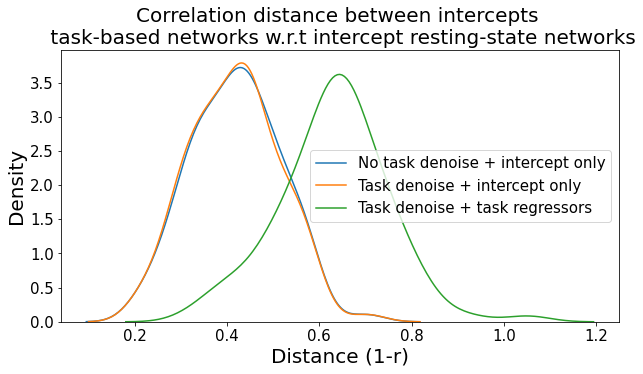

In [111]:
from scipy.spatial.distance import euclidean, correlation
import seaborn as sns
fig = plt.figure(figsize=(10,5))
sns.kdeplot([correlation(a,b) for (a,b) in zip(intercepts_1_scikit, intercepts_rest_scikit)], label="No task denoise + intercept only")
sns.kdeplot([correlation(a,b) for (a,b) in zip(intercepts_2_scikit, intercepts_rest_scikit)], label="Task denoise + intercept only" )
sns.kdeplot([correlation(a,b) for (a,b) in zip(intercepts_3_scikit, intercepts_rest_scikit)], label="Task denoise + task regressors")
plt.legend(fontsize=15)
plt.xlabel("Distance (1-r)", size=20)
plt.ylabel("Density", size=20)
plt.yticks(None)
plt.tick_params(labelsize=15)
plt.title("Correlation distance between intercepts \n task-based networks w.r.t intercept resting-state networks", size=20)

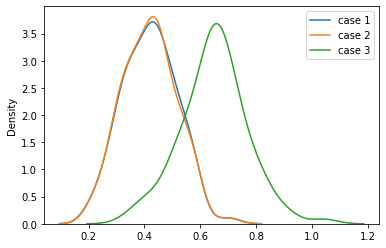

In [106]:
from scipy.spatial.distance import euclidean, correlation
import seaborn as sns
sns.kdeplot([correlation(a,b) for (a,b) in zip(intercepts_1, intercepts_rest)], label="case 1")
sns.kdeplot([correlation(a,b) for (a,b) in zip(intercepts_2, intercepts_rest)], label="case 2")
sns.kdeplot([correlation(a,b) for (a,b) in zip(intercepts_3, intercepts_rest)], label="case 3")
plt.legend()

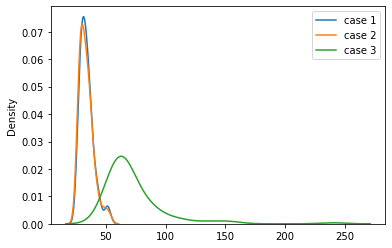

In [107]:
sns.kdeplot([euclidean(a,b) for (a,b) in zip(intercepts_1, intercepts_rest)], label="case 1")
sns.kdeplot([euclidean(a,b) for (a,b) in zip(intercepts_2, intercepts_rest)], label="case 2")
sns.kdeplot([euclidean(a,b) for (a,b) in zip(intercepts_3, intercepts_rest)], label="case 3")
plt.legend()

In [116]:
from scipy.stats import ttest_rel, friedmanchisquare
stat, pv = friedmanchisquare(*[[correlation(a,b) for (a,b) in zip(intercepts_1, intercepts_rest)], 
                               [correlation(a,b) for (a,b) in zip(intercepts_2, intercepts_rest)], 
                               [correlation(a,b) for (a,b) in zip(intercepts_3, intercepts_rest)]]
                            )

print("there are differneces, pv = ",pv)
print("doing post-hoc")
print(ttest_rel([correlation(a,b) for (a,b) in zip(intercepts_1, intercepts_rest)],
          [correlation(a,b) for (a,b) in zip(intercepts_2, intercepts_rest)]))
print(ttest_rel([correlation(a,b) for (a,b) in zip(intercepts_1, intercepts_rest)],
          [correlation(a,b) for (a,b) in zip(intercepts_3, intercepts_rest)]))
print(ttest_rel([correlation(a,b) for (a,b) in zip(intercepts_2, intercepts_rest)],
          [correlation(a,b) for (a,b) in zip(intercepts_3, intercepts_rest)]))
#ttest_rel()

there are differneces, pv =  9.85415468611124e-34
doing post-hoc
Ttest_relResult(statistic=1.3638826006922933, pvalue=0.17569750477725046)
Ttest_relResult(statistic=-23.023171832747057, pvalue=1.541252864199587e-41)
Ttest_relResult(statistic=-22.882767079460418, pvalue=2.568529792378405e-41)


In [144]:
t_map_1 = []
for (a,b) in zip(intercepts_1, intercepts_rest):
    r = np.corrcoef(a,b)[0,1]
    if r<0:
        r=0
    t_map_1.append(r)
    
t_map_2 = []
for (a,b) in zip(intercepts_2, intercepts_rest):
    r = np.corrcoef(a,b)[0,1]
    if r<0:
        r=0
    t_map_2.append(r)

t_map_3 = []
for (a,b) in zip(intercepts_3, intercepts_rest):
    r = np.corrcoef(a,b)[0,1]
    if r<0:
        r=0
    t_map_3.append(r)

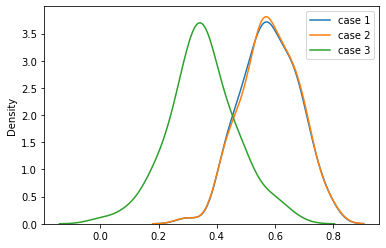

In [145]:
sns.kdeplot(t_map_1, label="case 1")
sns.kdeplot(t_map_2, label="case 2")
sns.kdeplot(t_map_3, label="case 3")
plt.legend()

In [94]:
print()
print([np.corrcoef(a,b)[0,1] for (a,b) in zip(intercepts_2, intercepts_rest)])
print([np.corrcoef(a,b)[0,1] for (a,b) in zip(intercepts_3, intercepts_rest)])

[0.4794443950630483, 0.6192617702207049, 0.42960658976211336, 0.5260005871616268, 0.4354527131082935, 0.5273646902501893, 0.7314124111793144, 0.6315602223163527, 0.5693050086964021, 0.7183527142716984]
[0.4800220202268969, 0.6211704787169657, 0.425899419371771, 0.5333131899664951, 0.43602957989524965, 0.5360152940293488, 0.7205488097658097, 0.6310737636626245, 0.5662354528490953, 0.7067851050639024]
[0.19187126705401708, -0.04384372206741252, 0.3568178110839079, 0.26458402466876757, 0.22596491632933788, 0.2798268992549463, 0.6127227254741446, 0.4005621652537816, 0.371082368400773, 0.4759824985249322]


In [41]:
# TODO: Añadir esto como test a la "libreria"
from nilearn.input_data import NiftiLabelsMasker
foo = NiftiLabelsMasker(labels_img=atlas_file, high_pass=1/187, t_r=2.0).fit_transform(run_imgs[0], confounds=conf_dfs[0])

np.corrcoef(squareform(np.mean(np.squeeze(edge_1.get_fdata()), axis=2)), 
            squareform(np.corrcoef(foo.T), checks=False))

array([[1., 1.],
       [1., 1.]])